# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to HTML, all the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---
### Why We're Here

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgement to classify these landmarks would not be feasible.

In this notebook, you will take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. At the end of this project, your code will accept any user-supplied image as input and suggest the top k most relevant landmarks from 50 possible landmarks from across the world. The image below displays a potential sample output of your finished project.

![Sample landmark classification output](images/sample_landmark_output.png)


### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Download Datasets and Install Python Modules
* [Step 1](#step1): Create a CNN to Classify Landmarks (from Scratch)
* [Step 2](#step2): Create a CNN to Classify Landmarks (using Transfer Learning)
* [Step 3](#step3): Write Your Landmark Prediction Algorithm

---
<a id='step0'></a>
## Step 0: Download Datasets and Install Python Modules

**Note: if you are using the Udacity workspace, *YOU CAN SKIP THIS STEP*. The dataset can be found in the `/data` folder and all required Python modules have been installed in the workspace.**

Download the [landmark dataset](https://udacity-dlnfd.s3-us-west-1.amazonaws.com/datasets/landmark_images.zip).
Unzip the folder and place it in this project's home directory, at the location `/landmark_images`.

Install the following Python modules:
* cv2
* matplotlib
* numpy
* PIL
* torch
* torchvision

---

<a id='step1'></a>
## Step 1: Create a CNN to Classify Landmarks (from Scratch)

In this step, you will create a CNN that classifies landmarks.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 20%.

Although 20% may seem low at first glance, it seems more reasonable after realizing how difficult of a problem this is. Many times, an image that is taken at a landmark captures a fairly mundane image of an animal or plant, like in the following picture.

<img src="images/train/00.Haleakala_National_Park/084c2aa50d0a9249.jpg" alt="Bird in Haleakalā National Park" style="width: 400px;"/>

Just by looking at that image alone, would you have been able to guess that it was taken at the Haleakalā National Park in Hawaii?

An accuracy of 20% is significantly better than random guessing, which would provide an accuracy of just 2%. In Step 2 of this notebook, you will have the opportunity to greatly improve accuracy by using transfer learning to create a CNN.

Remember that practice is far ahead of theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_scratch`. Your train data loader should be at `loaders_scratch['train']`, your validation data loader should be at `loaders_scratch['valid']`, and your test data loader should be at `loaders_scratch['test']`.

You may find [this documentation on custom datasets](https://pytorch.org/docs/stable/torchvision/datasets.html#datasetfolder) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [148]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

batch_size = 20 
torch.manual_seed(4)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((243, 243)),
    transforms.RandomHorizontalFlip(p=0.1), 
    transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomRotation(30),
    transforms.RandomInvert(p=0.1),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((243, 243)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.6, 0.5, 0.5))])

#I DID TAKE REFRENCE FROM THIS GITHUB ABOUT HOW TO SPLIT TEST AND VALID DATASETS WITH DIFFRENT TRANSFORMS
#https://gist.github.com/kevinzakka/d33bf8d6c7f06a9d8c76d97a7879f5cb
train_dataset = datasets.ImageFolder('landmark_images/train', transform=train_transform)
valid_dataset = datasets.ImageFolder('landmark_images/train', transform=test_transform)
test_dataset = datasets.ImageFolder('landmark_images/test', transform=test_transform)

num_train = len(train_dataset)  
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


loaders_scratch = {'train': torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler),
                   'valid': torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_sampler),
                   'test': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)}

**Question 1:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:
##### How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
I didn't use cropping because I through that the landmarks are quit large so by cropping the image I may lose part of the landmark so I just resized the picture.
I chosee the size of 234*234 i didn't want to have a small size and since I used maxpolling layer with a stride of 3 I wanted to have a size that is of the multiplication of 3 to make the math more simple.
##### Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?
yes I did use augmentation because the dataset seems to be small and I wanted to add variation to it.
I used both vertical and horizontal flips, 
rotation with a 30 degree 
and a color invert.

### (IMPLEMENTATION) Visualize a Batch of Training Data

Use the code cell below to retrieve a batch of images from your train data loader, display at least 5 images simultaneously, and label each displayed image with its class name (e.g., "Golden Gate Bridge").

Visualizing the output of your data loader is a great way to ensure that your data loading and preprocessing are working as expected.

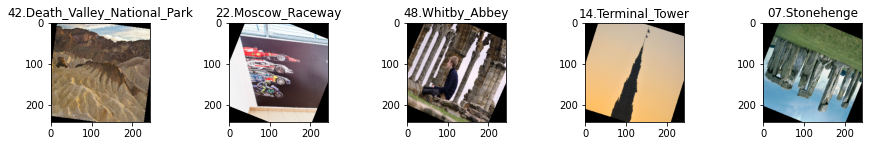

In [149]:
import matplotlib.pyplot as plt
%matplotlib inline

## TODO: visualize a batch of the train data loader

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

dataiter = iter(loaders_scratch['train'])
images, labels = dataiter.next()
images = images.numpy()

figure = plt.figure(figsize=(25, 4))

for i in np.arange(5):
    ax = figure.add_subplot(2, 8, i+1)
    images[i] = images[i] / 2 + 0.5
    plt.imshow(np.transpose(images[i], (1, 2, 0)))
    ax.set_title(train_dataset.classes[labels[i]])



### Initialize use_cuda variable

In [150]:
# useful variable that tells us whether we should use the GPU
use_cuda = torch.cuda.is_available()


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and fill in the function `get_optimizer_scratch` below.

In [151]:
## TODO: select loss function
import torch.optim as optim

criterion_scratch = torch.nn.CrossEntropyLoss()

def get_optimizer_scratch(model):
    ## TODO: select and return an optimizer
    return optim.Adam(model.parameters(), lr= 0.0001)
    

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify images of landmarks.  Use the template in the code cell below.

In [152]:
import torch.nn as nn
import torch.nn.functional as F
# define the CNN architecture
class Net(nn.Module):
    ## TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        
        ## Define layers of a CNN
        
        self.conv1 = nn.Conv2d(3, 32, 5, padding=2)
       
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
       
        self.conv3 = nn.Conv2d(64, 128, 5, padding=2)
        
        self.conv4 = nn.Conv2d(128, 256, 5, padding=2)
        
        self.pool = nn.MaxPool2d(3, 3)
        
        self.fc1 = nn.Linear(256 * 3 * 3, 50)
        
        self.fc2 = nn.Linear(50, 50)
        
        self.dropout = nn.Dropout(0.3)
        
        
    
    def forward(self, x):
        ## Define forward behavior

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        
        x = x.view(x.shape[0], -1)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        
        
        return x

#-#-# Do NOT modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()
    

__Question 2:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

I did have a general framework in my mind at the start which was 3-6 convolutional layers 1 fully connected layer.
while testing i faced a few major problems which led me to this architecture which was 

###### my gpu memory wasn't enough :
at the start the model wouldn't train because of the gpu memory so i decide to reduce the input size to the fully connected layer which was large so I used a polling layer with a stride of three to minimize the output size of convolutional layers without adding more additional convolutional layers or reducing the feature maps.
###### overfitting:
it made me split the transformers of the training and the validation data sets, and add one more fully connected layer to make use of the dropout
###### I didn't pay much attetion to the learning rate at the start:
so I started to test a few diffrent learning rates every time I change the architecture.

### (IMPLEMENTATION) Implement the Training Algorithm

Implement your training algorithm in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at the filepath stored in the variable `save_path`.

In [153]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        # set the module to training mode
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))

            optimizer.zero_grad()
            
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
        
            
        
        ######################    
        # validate the model #
        ######################
        # set the model to evaluation mode
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            ## TODO: update average validation loss 
            
            output = model(data) 
            loss = criterion(output, target)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))      
            
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        ## TODO: if the validation loss has decreased, save the model at the filepath stored in save_path
        
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
        
        
    return model

### (IMPLEMENTATION) Experiment with the Weight Initialization

Use the code cell below to define a custom weight initialization, and then train with your weight initialization for a few epochs. Make sure that neither the training loss nor validation loss is `nan`.

Later on, you will be able to see how this compares to training with PyTorch's default weight initialization.

In [154]:
def custom_weight_init(m):
    ## TODO: implement a weight initialization strategy
    classname = m.__class__.__name__
    
    if classname.find('Linear') != -1:
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)
    
#-#-# Do NOT modify the code below this line. #-#-#
    
model_scratch.apply(custom_weight_init)
model_scratch = train(20, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch),
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.911283 	Validation Loss: 3.915169
Validation loss decreased (inf --> 3.915169).  Saving model ...
Epoch: 2 	Training Loss: 3.901202 	Validation Loss: 3.890521
Validation loss decreased (3.915169 --> 3.890521).  Saving model ...
Epoch: 3 	Training Loss: 3.873130 	Validation Loss: 3.847903
Validation loss decreased (3.890521 --> 3.847903).  Saving model ...
Epoch: 4 	Training Loss: 3.826642 	Validation Loss: 3.798034
Validation loss decreased (3.847903 --> 3.798034).  Saving model ...
Epoch: 5 	Training Loss: 3.777703 	Validation Loss: 3.757424
Validation loss decreased (3.798034 --> 3.757424).  Saving model ...
Epoch: 6 	Training Loss: 3.738945 	Validation Loss: 3.674274
Validation loss decreased (3.757424 --> 3.674274).  Saving model ...
Epoch: 7 	Training Loss: 3.681411 	Validation Loss: 3.599291
Validation loss decreased (3.674274 --> 3.599291).  Saving model ...
Epoch: 8 	Training Loss: 3.626911 	Validation Loss: 3.547820
Validation loss decreased (3.59929

### (IMPLEMENTATION) Train and Validate the Model

Run the next code cell to train your model.

In [49]:
## TODO: you may change the number of epochs if you'd like,
## but changing it is not required
num_epochs = 100

#-#-# Do NOT modify the code below this line. #-#-#

# function to re-initialize a model with pytorch's default weight initialization
def default_weight_init(m):
    reset_parameters = getattr(m, 'reset_parameters', None)
    if callable(reset_parameters):
        m.reset_parameters()

# reset the model parameters
model_scratch.apply(default_weight_init)

# train the model
model_scratch = train(num_epochs, loaders_scratch, model_scratch, get_optimizer_scratch(model_scratch), 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

Epoch: 1 	Training Loss: 3.916026 	Validation Loss: 3.911596
Validation loss decreased (inf --> 3.911596).  Saving model ...
Epoch: 2 	Training Loss: 3.903458 	Validation Loss: 3.892034
Validation loss decreased (3.911596 --> 3.892034).  Saving model ...
Epoch: 3 	Training Loss: 3.884694 	Validation Loss: 3.879456
Validation loss decreased (3.892034 --> 3.879456).  Saving model ...
Epoch: 4 	Training Loss: 3.864348 	Validation Loss: 3.844037
Validation loss decreased (3.879456 --> 3.844037).  Saving model ...
Epoch: 5 	Training Loss: 3.846021 	Validation Loss: 3.827867
Validation loss decreased (3.844037 --> 3.827867).  Saving model ...
Epoch: 6 	Training Loss: 3.807526 	Validation Loss: 3.773720
Validation loss decreased (3.827867 --> 3.773720).  Saving model ...
Epoch: 7 	Training Loss: 3.775134 	Validation Loss: 3.752638
Validation loss decreased (3.773720 --> 3.752638).  Saving model ...
Epoch: 8 	Training Loss: 3.748931 	Validation Loss: 3.735960
Validation loss decreased (3.75263

Epoch: 98 	Training Loss: 1.649150 	Validation Loss: 2.908793
Epoch: 99 	Training Loss: 1.595755 	Validation Loss: 2.865156
Epoch: 100 	Training Loss: 1.615323 	Validation Loss: 2.931596


### (IMPLEMENTATION) Test the Model

Run the code cell below to try out your model on the test dataset of landmark images. Run the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 20%.

In [50]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    # set the module to evaluation mode
    model.eval()

    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data.item() - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.490576


Test Accuracy: 37% (468/1250)


---
<a id='step2'></a>
## Step 2: Create a CNN to Classify Landmarks (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify landmarks from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Landmark Dataset

Use the code cell below to create three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader): one for training data, one for validation data, and one for test data. Randomly split the images located at `landmark_images/train` to create the train and validation data loaders, and use the images located at `landmark_images/test` to create the test data loader.

All three of your data loaders should be accessible via a dictionary named `loaders_transfer`. Your train data loader should be at `loaders_transfer['train']`, your validation data loader should be at `loaders_transfer['valid']`, and your test data loader should be at `loaders_transfer['test']`.

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [119]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes
batch_size = 20 
torch.manual_seed(4)

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.1), 
    transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomRotation(30),
    transforms.RandomInvert(p=0.1),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.6, 0.5, 0.5))])

#I DID TAKE REFRENCE FROM THIS GITHUB ABOUT HOW TO SPLIT TEST AND VALID DATASETS WITH DIFFRENT TRANSFORMS
#https://gist.github.com/kevinzakka/d33bf8d6c7f06a9d8c76d97a7879f5cb
train_dataset = datasets.ImageFolder('landmark_images/train', transform=train_transform)
valid_dataset = datasets.ImageFolder('landmark_images/train', transform=test_transform)
test_dataset = datasets.ImageFolder('landmark_images/test', transform=test_transform)

num_train = len(train_dataset)  
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(0.2 * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)


loaders_transfer = {'train': torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler),
                   'valid': torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_sampler),
                   'test': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)}

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_transfer`, and fill in the function `get_optimizer_transfer` below.

In [111]:
## TODO: select loss function
criterion_transfer = nn.CrossEntropyLoss()


def get_optimizer_transfer(model):
    ## TODO: select and return optimizer
    return optim.SGD(model.fc.parameters(), lr=0.001)
    
    

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify images of landmarks.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [162]:
## TODO: Specify model architecture
from torchvision import models

model_transfer = models.resnet152(pretrained=True)

for parameters in model_transfer.parameters():
    parameters.requires_grad = False

model_transfer.fc = nn.Linear(2048, 50)

#-#-# Do NOT modify the code below this line. #-#-#

if use_cuda:
    model_transfer = model_transfer.cuda()

__Question 3:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

I wanted to try to train the model with a high number of epochs since I did hear that the more complex the architecture the more epochs It needs to be trained to reach it's optimal state, and resnet is the most complex architecture that I know of, also I was amazed by the resnet architecture espically since it solved the Vanishing gradient problem, which was a problem I have been hearing about since I learned deep learning so I decided to use resnet in the end.


I downloaded the resnet152 freezed it's parameters and then changed the last layer to the same input size but with diffrent output size (50) which is the number of classes for this classfication problem, since I think that even throught the imagenet dataset doesn't specifically has landmarks but most of the pictures taken should have one in the background so i wanted to make use of the feature maps of convolutional layers.


### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [113]:
# TODO: train the model and save the best model parameters at filepath 'model_transfer.pt'
epochs = 1000
valid_loss_min = np.Inf
optimizer = get_optimizer_transfer(model_transfer)
for epoch in range(1, epochs+1):  
    train_loss = 0.0
    valid_loss = 0.0

    model_transfer.train()
    for batch_idx, (data, target) in enumerate(loaders_transfer['train']):
        if use_cuda:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
            
        output = model_transfer(data)
        loss = criterion_transfer(output, target)
        loss.backward()
        optimizer.step()
        train_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - train_loss))
            
    model_transfer.eval()
    for batch_idx, (data, target) in enumerate(loaders_transfer['valid']):
        if use_cuda:
            data, target = data.cuda(), target.cuda()
   
        output = model_transfer(data) 
        loss = criterion_transfer(output, target)
        valid_loss += ((1 / (batch_idx + 1)) * (loss.data.item() - valid_loss))      
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))

        
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
        torch.save(model_transfer.state_dict(), 'model_transfer.pt')
        valid_loss_min = valid_loss


#-#-# Do NOT modify the code below this line. #-#-#

# load the model that got the best validation accuracy
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

Epoch: 1 	Training Loss: 3.895177 	Validation Loss: 3.845143
Validation loss decreased (inf --> 3.845143).  Saving model ...
Epoch: 2 	Training Loss: 3.770546 	Validation Loss: 3.743919
Validation loss decreased (3.845143 --> 3.743919).  Saving model ...
Epoch: 3 	Training Loss: 3.663597 	Validation Loss: 3.639534
Validation loss decreased (3.743919 --> 3.639534).  Saving model ...
Epoch: 4 	Training Loss: 3.551731 	Validation Loss: 3.545449
Validation loss decreased (3.639534 --> 3.545449).  Saving model ...
Epoch: 5 	Training Loss: 3.457229 	Validation Loss: 3.453937
Validation loss decreased (3.545449 --> 3.453937).  Saving model ...
Epoch: 6 	Training Loss: 3.368573 	Validation Loss: 3.369542
Validation loss decreased (3.453937 --> 3.369542).  Saving model ...
Epoch: 7 	Training Loss: 3.281063 	Validation Loss: 3.286235
Validation loss decreased (3.369542 --> 3.286235).  Saving model ...
Epoch: 8 	Training Loss: 3.194529 	Validation Loss: 3.193153
Validation loss decreased (3.28623

Epoch: 72 	Training Loss: 1.591566 	Validation Loss: 1.615807
Validation loss decreased (1.621457 --> 1.615807).  Saving model ...
Epoch: 73 	Training Loss: 1.576396 	Validation Loss: 1.602538
Validation loss decreased (1.615807 --> 1.602538).  Saving model ...
Epoch: 74 	Training Loss: 1.559489 	Validation Loss: 1.613049
Epoch: 75 	Training Loss: 1.566611 	Validation Loss: 1.602661
Epoch: 76 	Training Loss: 1.556562 	Validation Loss: 1.602605
Epoch: 77 	Training Loss: 1.546239 	Validation Loss: 1.566389
Validation loss decreased (1.602538 --> 1.566389).  Saving model ...
Epoch: 78 	Training Loss: 1.551113 	Validation Loss: 1.577711
Epoch: 79 	Training Loss: 1.527103 	Validation Loss: 1.557912
Validation loss decreased (1.566389 --> 1.557912).  Saving model ...
Epoch: 80 	Training Loss: 1.534161 	Validation Loss: 1.570658
Epoch: 81 	Training Loss: 1.522513 	Validation Loss: 1.569768
Epoch: 82 	Training Loss: 1.529472 	Validation Loss: 1.556052
Validation loss decreased (1.557912 --> 1.

Epoch: 172 	Training Loss: 1.237256 	Validation Loss: 1.326152
Epoch: 173 	Training Loss: 1.234097 	Validation Loss: 1.308831
Epoch: 174 	Training Loss: 1.235096 	Validation Loss: 1.357504
Epoch: 175 	Training Loss: 1.219160 	Validation Loss: 1.319926
Epoch: 176 	Training Loss: 1.221426 	Validation Loss: 1.313974
Epoch: 177 	Training Loss: 1.221697 	Validation Loss: 1.321494
Epoch: 178 	Training Loss: 1.229949 	Validation Loss: 1.314803
Epoch: 179 	Training Loss: 1.225291 	Validation Loss: 1.295705
Validation loss decreased (1.302002 --> 1.295705).  Saving model ...
Epoch: 180 	Training Loss: 1.217898 	Validation Loss: 1.285887
Validation loss decreased (1.295705 --> 1.285887).  Saving model ...
Epoch: 181 	Training Loss: 1.227315 	Validation Loss: 1.280512
Validation loss decreased (1.285887 --> 1.280512).  Saving model ...
Epoch: 182 	Training Loss: 1.220976 	Validation Loss: 1.321592
Epoch: 183 	Training Loss: 1.203378 	Validation Loss: 1.307659
Epoch: 184 	Training Loss: 1.219409 	

Epoch: 285 	Training Loss: 1.072618 	Validation Loss: 1.215455
Epoch: 286 	Training Loss: 1.083461 	Validation Loss: 1.251821
Epoch: 287 	Training Loss: 1.088437 	Validation Loss: 1.231151
Epoch: 288 	Training Loss: 1.082833 	Validation Loss: 1.219422
Epoch: 289 	Training Loss: 1.080111 	Validation Loss: 1.228705
Epoch: 290 	Training Loss: 1.065111 	Validation Loss: 1.224866
Epoch: 291 	Training Loss: 1.078608 	Validation Loss: 1.228110
Epoch: 292 	Training Loss: 1.057789 	Validation Loss: 1.225049
Epoch: 293 	Training Loss: 1.055394 	Validation Loss: 1.235932
Epoch: 294 	Training Loss: 1.083245 	Validation Loss: 1.229004
Epoch: 295 	Training Loss: 1.069121 	Validation Loss: 1.232177
Epoch: 296 	Training Loss: 1.058135 	Validation Loss: 1.198047
Epoch: 297 	Training Loss: 1.071533 	Validation Loss: 1.218776
Epoch: 298 	Training Loss: 1.066168 	Validation Loss: 1.230080
Epoch: 299 	Training Loss: 1.076374 	Validation Loss: 1.221672
Epoch: 300 	Training Loss: 1.069414 	Validation Loss: 1

Epoch: 406 	Training Loss: 0.975093 	Validation Loss: 1.207779
Epoch: 407 	Training Loss: 0.980367 	Validation Loss: 1.192878
Epoch: 408 	Training Loss: 0.985189 	Validation Loss: 1.190570
Epoch: 409 	Training Loss: 0.999291 	Validation Loss: 1.185362
Epoch: 410 	Training Loss: 1.003853 	Validation Loss: 1.182292
Epoch: 411 	Training Loss: 0.983683 	Validation Loss: 1.206956
Epoch: 412 	Training Loss: 0.983746 	Validation Loss: 1.204205
Epoch: 413 	Training Loss: 0.984064 	Validation Loss: 1.205970
Epoch: 414 	Training Loss: 0.995823 	Validation Loss: 1.195365
Epoch: 415 	Training Loss: 0.999693 	Validation Loss: 1.189222
Epoch: 416 	Training Loss: 0.973283 	Validation Loss: 1.207199
Epoch: 417 	Training Loss: 1.002664 	Validation Loss: 1.197872
Epoch: 418 	Training Loss: 0.977345 	Validation Loss: 1.197830
Epoch: 419 	Training Loss: 0.969030 	Validation Loss: 1.173702
Epoch: 420 	Training Loss: 0.968517 	Validation Loss: 1.182768
Epoch: 421 	Training Loss: 0.969641 	Validation Loss: 1

Epoch: 533 	Training Loss: 0.918402 	Validation Loss: 1.163029
Epoch: 534 	Training Loss: 0.910808 	Validation Loss: 1.210678
Epoch: 535 	Training Loss: 0.914185 	Validation Loss: 1.191112
Epoch: 536 	Training Loss: 0.933283 	Validation Loss: 1.173709
Epoch: 537 	Training Loss: 0.944839 	Validation Loss: 1.160801
Epoch: 538 	Training Loss: 0.919372 	Validation Loss: 1.159010
Epoch: 539 	Training Loss: 0.918657 	Validation Loss: 1.169115
Epoch: 540 	Training Loss: 0.919132 	Validation Loss: 1.176355
Epoch: 541 	Training Loss: 0.910781 	Validation Loss: 1.153724
Epoch: 542 	Training Loss: 0.939950 	Validation Loss: 1.144609
Epoch: 543 	Training Loss: 0.915794 	Validation Loss: 1.173632
Epoch: 544 	Training Loss: 0.931743 	Validation Loss: 1.167485
Epoch: 545 	Training Loss: 0.911508 	Validation Loss: 1.178559
Epoch: 546 	Training Loss: 0.913595 	Validation Loss: 1.195592
Epoch: 547 	Training Loss: 0.918241 	Validation Loss: 1.177353
Epoch: 548 	Training Loss: 0.920140 	Validation Loss: 1

Epoch: 662 	Training Loss: 0.867394 	Validation Loss: 1.186973
Epoch: 663 	Training Loss: 0.865399 	Validation Loss: 1.150170
Epoch: 664 	Training Loss: 0.874984 	Validation Loss: 1.166074
Epoch: 665 	Training Loss: 0.852090 	Validation Loss: 1.173629
Epoch: 666 	Training Loss: 0.852268 	Validation Loss: 1.166891
Epoch: 667 	Training Loss: 0.861641 	Validation Loss: 1.152848
Epoch: 668 	Training Loss: 0.870803 	Validation Loss: 1.146444
Epoch: 669 	Training Loss: 0.869282 	Validation Loss: 1.156516
Epoch: 670 	Training Loss: 0.860900 	Validation Loss: 1.150267
Epoch: 671 	Training Loss: 0.874936 	Validation Loss: 1.144223
Epoch: 672 	Training Loss: 0.881020 	Validation Loss: 1.176992
Epoch: 673 	Training Loss: 0.876019 	Validation Loss: 1.147318
Epoch: 674 	Training Loss: 0.873625 	Validation Loss: 1.176315
Epoch: 675 	Training Loss: 0.893573 	Validation Loss: 1.146137
Epoch: 676 	Training Loss: 0.863531 	Validation Loss: 1.153879
Epoch: 677 	Training Loss: 0.872933 	Validation Loss: 1

Epoch: 790 	Training Loss: 0.856064 	Validation Loss: 1.166900
Epoch: 791 	Training Loss: 0.833214 	Validation Loss: 1.168385
Epoch: 792 	Training Loss: 0.837773 	Validation Loss: 1.146689
Epoch: 793 	Training Loss: 0.831476 	Validation Loss: 1.151664
Epoch: 794 	Training Loss: 0.851816 	Validation Loss: 1.182067
Epoch: 795 	Training Loss: 0.843197 	Validation Loss: 1.155350
Epoch: 796 	Training Loss: 0.838174 	Validation Loss: 1.140820
Epoch: 797 	Training Loss: 0.817621 	Validation Loss: 1.171024
Epoch: 798 	Training Loss: 0.848930 	Validation Loss: 1.170553
Epoch: 799 	Training Loss: 0.808730 	Validation Loss: 1.173139
Epoch: 800 	Training Loss: 0.833716 	Validation Loss: 1.156306
Epoch: 801 	Training Loss: 0.850267 	Validation Loss: 1.166595
Epoch: 802 	Training Loss: 0.835609 	Validation Loss: 1.149984
Epoch: 803 	Training Loss: 0.836547 	Validation Loss: 1.171848
Epoch: 804 	Training Loss: 0.828147 	Validation Loss: 1.158935
Epoch: 805 	Training Loss: 0.828473 	Validation Loss: 1

Epoch: 921 	Training Loss: 0.807744 	Validation Loss: 1.153234
Epoch: 922 	Training Loss: 0.793806 	Validation Loss: 1.127325
Epoch: 923 	Training Loss: 0.799377 	Validation Loss: 1.162502
Epoch: 924 	Training Loss: 0.797171 	Validation Loss: 1.132964
Epoch: 925 	Training Loss: 0.806048 	Validation Loss: 1.176246
Epoch: 926 	Training Loss: 0.807466 	Validation Loss: 1.160380
Epoch: 927 	Training Loss: 0.789492 	Validation Loss: 1.161214
Epoch: 928 	Training Loss: 0.780471 	Validation Loss: 1.165687
Epoch: 929 	Training Loss: 0.826542 	Validation Loss: 1.158934
Epoch: 930 	Training Loss: 0.811354 	Validation Loss: 1.136567
Epoch: 931 	Training Loss: 0.822190 	Validation Loss: 1.157780
Epoch: 932 	Training Loss: 0.808016 	Validation Loss: 1.153839
Epoch: 933 	Training Loss: 0.813388 	Validation Loss: 1.164622
Epoch: 934 	Training Loss: 0.790147 	Validation Loss: 1.162075
Epoch: 935 	Training Loss: 0.782503 	Validation Loss: 1.127099
Epoch: 936 	Training Loss: 0.793841 	Validation Loss: 1

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of landmark images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [120]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.970045


Test Accuracy: 74% (930/1250)


---
<a id='step3'></a>
## Step 3: Write Your Landmark Prediction Algorithm

Great job creating your CNN models! Now that you have put in all the hard work of creating accurate classifiers, let's define some functions to make it easy for others to use your classifiers.

### (IMPLEMENTATION) Write Your Algorithm, Part 1

Implement the function `predict_landmarks`, which accepts a file path to an image and an integer k, and then predicts the **top k most likely landmarks**. You are **required** to use your transfer learned CNN from Step 2 to predict the landmarks.

An example of the expected behavior of `predict_landmarks`:
```
>>> predicted_landmarks = predict_landmarks('example_image.jpg', 3)
>>> print(predicted_landmarks)
['Golden Gate Bridge', 'Brooklyn Bridge', 'Sydney Harbour Bridge']
```

In [156]:
import cv2
from PIL import Image

## the class names can be accessed at the `classes` attribute
## of your dataset object (e.g., `train_dataset.classes`)

def predict_landmarks(img_path, k):
    ## TODO: return the names of the top k landmarks predicted by the transfer learned CNN
    classes = []
    classes = list(train_dataset.classes)
    
    for i in range(len(classes)):
        classes[i] = classes[i][3:]
        String_list = classes[i].split('_')
        String_Class = String_list[0]
        index = 0
        for j in String_list:
            if index > 0:
                String_Class += ' ' + j
            else: index += 1
        classes[i] = String_Class
    
    test_transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Resize((224, 224)),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.6, 0.5, 0.5))])
    img = plt.imread(img_path)
    img = test_transform(img)
    img.unsqueeze_(0)
    
    if use_cuda:
        img = img.cuda()  
    model_transfer.eval()
    model_output = model_transfer(img)
    predection, class_ = torch.topk(model_output, k)
    
    result = [classes[class_[0][i]] for i in range(k)]
    
    return result
# test on a sample image
predict_landmarks('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg', 5)

['Golden Gate Bridge',
 'Brooklyn Bridge',
 'Dead Sea',
 'Forth Bridge',
 'Sydney Harbour Bridge']

### (IMPLEMENTATION) Write Your Algorithm, Part 2

In the code cell below, implement the function `suggest_locations`, which accepts a file path to an image as input, and then displays the image and the **top 3 most likely landmarks** as predicted by `predict_landmarks`.

Some sample output for `suggest_locations` is provided below, but feel free to design your own user experience!
![](images/sample_landmark_output.png)

is this picture of the
Golden Gate Bridge, 
Brooklyn Bridge, 
or Dead Sea


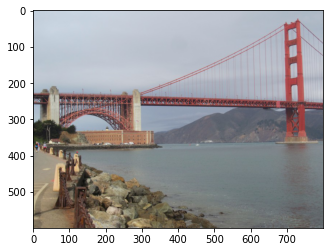

In [157]:
def suggest_locations(img_path):
    # get landmark predictions
    predicted_landmarks = predict_landmarks(img_path, 3)
    
    ## TODO: display image and display landmark predictions

    landmarks = predict_landmarks(img_path, 3)
    
    img = plt.imread(img_path)
    plt.imshow(img)
    
    string ='is this picture of the\n{}, \n{}, \nor {}'.format(landmarks[0], landmarks[1], landmarks[2])
    print(string)

# test on a sample image
suggest_locations('images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg')

### (IMPLEMENTATION) Test Your Algorithm

Test your algorithm by running the `suggest_locations` function on at least four images on your computer. Feel free to use any images you like.

__Question 4:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

I was expecting a better result but i think it can be improved by:

1-increasing the training dataset since 4000 is quite small for a slightly complex classification problem like landmarks.

2-improve the architucture of the model if by using transfer learning I think it may be better to keep the start of the convolutional layer only since the dataset doesn't seems to be too similar to the one used by imagenet.

3-solving overfitting with many diffrent approaches, overfitting seemed to be quite a problem from my point of view. 

is this picture of the
Sydney Opera House, 
Vienna City Hall, 
or Forth Bridge


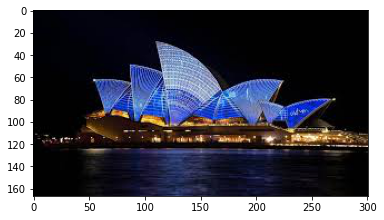

In [158]:
## TODO: Execute the `suggest_locations` function on
## at least 4 images on your computer.
## Feel free to use as many code cells as needed.
suggest_locations('test_1.jpg')


is this picture of the
Gullfoss Falls, 
Badlands National Park, 
or Dead Sea


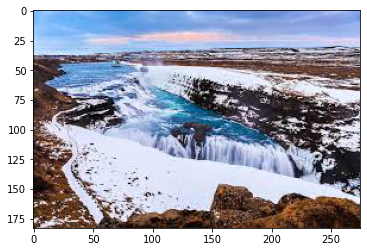

In [159]:
suggest_locations('test_2.jpg')

is this picture of the
Temple of Heaven, 
Stockholm City Hall, 
or Changdeokgung


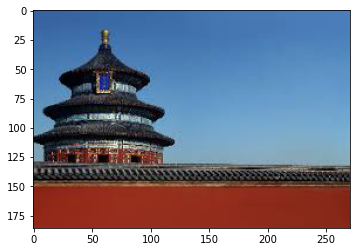

In [160]:
suggest_locations('test_3.jpg')

is this picture of the
Terminal Tower, 
Stockholm City Hall, 
or Central Park


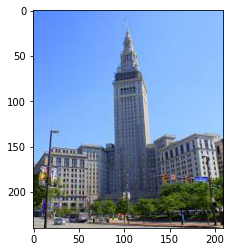

In [161]:
suggest_locations('test_4.jpg')